In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import itertools
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm
from time import time
import PIL
from PIL import Image

In [2]:
device = torch.device("cpu")

In [3]:
root_dir = os.getcwd()
dataset_dir = os.path.join(root_dir, "fruits-360")

In [4]:
tensor_transform = transforms.Compose([
    transforms.ToTensor()])
    
train_dataset = ImageFolder(os.path.join(dataset_dir, 'Training'), tensor_transform)
test_dataset = ImageFolder(os.path.join(dataset_dir, 'Test'), tensor_transform)

In [5]:
print(dict(Counter(train_dataset.targets)))
print(f"number of class is : {len(dict(Counter(train_dataset.targets)))}")

{0: 492, 1: 444, 2: 480, 3: 492, 4: 481, 5: 492, 6: 456, 7: 492, 8: 492, 9: 429, 10: 490, 11: 492, 12: 672, 13: 492, 14: 427, 15: 491, 16: 490, 17: 450, 18: 490, 19: 450, 20: 462, 21: 490, 22: 492, 23: 492, 24: 490, 25: 702, 26: 492, 27: 738, 28: 738, 29: 492, 30: 492, 31: 492, 32: 450, 33: 490, 34: 490, 35: 450, 36: 462, 37: 392, 38: 468, 39: 490, 40: 468, 41: 702, 42: 297, 43: 490, 44: 984, 45: 492, 46: 490, 47: 490, 48: 492, 49: 471, 50: 490, 51: 492, 52: 490, 53: 464, 54: 490, 55: 490, 56: 466, 57: 471, 58: 490, 59: 492, 60: 490, 61: 490, 62: 490, 63: 490, 64: 490, 65: 426, 66: 300, 67: 490, 68: 738, 69: 492, 70: 492, 71: 480, 72: 654, 73: 534, 74: 450, 75: 445, 76: 438, 77: 479, 78: 492, 79: 490, 80: 492, 81: 738, 82: 492, 83: 492, 84: 696, 85: 490, 86: 702, 87: 300, 88: 490, 89: 666, 90: 711, 91: 490, 92: 490, 93: 444, 94: 702, 95: 666, 96: 666, 97: 492, 98: 492, 99: 490, 100: 493, 101: 490, 102: 447, 103: 420, 104: 900, 105: 492, 106: 450, 107: 450, 108: 453, 109: 450, 110: 450,

In [6]:
N_CHANNELS = 3

full_loader = DataLoader(dataset=train_dataset, shuffle=False, num_workers=os.cpu_count())

before = time()
mean = torch.zeros(3)
std = torch.zeros(3)
print('==> Computing mean and std..')
for inputs, _labels in tqdm(full_loader):
    for i in range(N_CHANNELS):
        mean[i] += inputs[:,i,:,:].mean()
        std[i] += inputs[:,i,:,:].std()
mean.div_(len(train_dataset))
std.div_(len(train_dataset))
print(mean, std)

print("time elapsed: ", time()-before)

==> Computing mean and std..


  0%|          | 0/67692 [00:00<?, ?it/s]

tensor([0.6840, 0.5786, 0.5037]) tensor([0.2586, 0.3219, 0.3662])
time elapsed:  73.60690379142761


In [7]:
mean = [0.6840, 0.5786, 0.5037]
std = [0.2586, 0.3219, 0.3662]

tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),
                        torch.Tensor(std)) 
])

train_dataset = ImageFolder(os.path.join(dataset_dir, 'Training'), tensor_transform)
test_dataset = ImageFolder(os.path.join(dataset_dir, 'Test'), tensor_transform)

In [8]:
#hyperparameters
batch_size = 16

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=1,
                         shuffle=False)

In [9]:
epochs = 5
learning_rate = 0.001

width = 100
height = 100
n_channel = 3

classes = os.listdir(dataset_dir + "/Training")

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(n_channel, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32*9*9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 32*9*9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)       
        return x

In [12]:
model = ConvNet()

criteration = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)

In [13]:
# train
before = time()
loss_values = []
for epoch in range(epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        
        # forward
        outputs = model(images)
        loss = criteration(outputs, labels)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0) 
        
        if (i + 1) % 200 == 0:
            print(f"epoch {epoch + 1}/{epochs}, step {i+1}/{n_total_steps}, loss {loss.item():.4f}")
    
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
print("time elapsed: ", time()-before)

epoch 1/5, step 200/4231, loss 3.3302
epoch 1/5, step 400/4231, loss 2.1272
epoch 1/5, step 600/4231, loss 1.2694
epoch 1/5, step 800/4231, loss 0.6988
epoch 1/5, step 1000/4231, loss 0.5456
epoch 1/5, step 1200/4231, loss 0.2821
epoch 1/5, step 1400/4231, loss 0.2207
epoch 1/5, step 1600/4231, loss 0.6768
epoch 1/5, step 1800/4231, loss 0.0806
epoch 1/5, step 2000/4231, loss 0.2264
epoch 1/5, step 2200/4231, loss 0.1180
epoch 1/5, step 2400/4231, loss 0.2984
epoch 1/5, step 2600/4231, loss 0.0598
epoch 1/5, step 2800/4231, loss 0.0551
epoch 1/5, step 3000/4231, loss 0.1180
epoch 1/5, step 3200/4231, loss 0.0010
epoch 1/5, step 3400/4231, loss 0.4371
epoch 1/5, step 3600/4231, loss 0.0041
epoch 1/5, step 3800/4231, loss 0.4356
epoch 1/5, step 4000/4231, loss 0.2650
epoch 1/5, step 4200/4231, loss 0.3914
epoch 2/5, step 200/4231, loss 0.0410
epoch 2/5, step 400/4231, loss 0.0025
epoch 2/5, step 600/4231, loss 0.0076
epoch 2/5, step 800/4231, loss 0.0205
epoch 2/5, step 1000/4231, loss 0

Text(0,0.5,'loss')

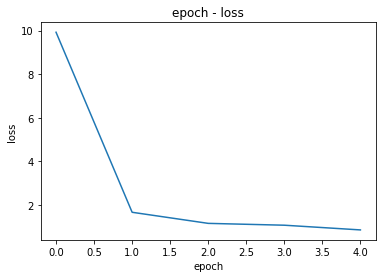

In [14]:
plt.plot(loss_values)
plt.title("epoch - loss")
plt.xlabel("epoch")
plt.ylabel("loss")

In [22]:
# test
conf_matrix = np.zeros(shape=(len(classes),len(classes)))
with torch.no_grad():
    for image, label in tqdm(test_loader):
        output = model(image)
        # value, index
        _, prediction = torch.max(output, 1)
        
        conf_matrix[label][prediction] += 1

  0%|          | 0/22688 [00:00<?, ?it/s]

In [23]:
correct = 0
for i in range(len(conf_matrix)):
    correct += conf_matrix[i][i]
    
acc = correct / len(test_loader)
recall = np.mean(np.diag(conf_matrix) / np.sum(conf_matrix, axis = 1))
precision = np.mean(np.diag(conf_matrix) / np.sum(conf_matrix, axis = 0))

In [24]:
print(f"overall accuracy is {acc:.2f}")
print(f"overall precision is {precision:.2f}")
print(f"overall recall is {recall:.2f}")

overall accuracy is 0.92
overall precision is 0.93
overall recall is 0.91


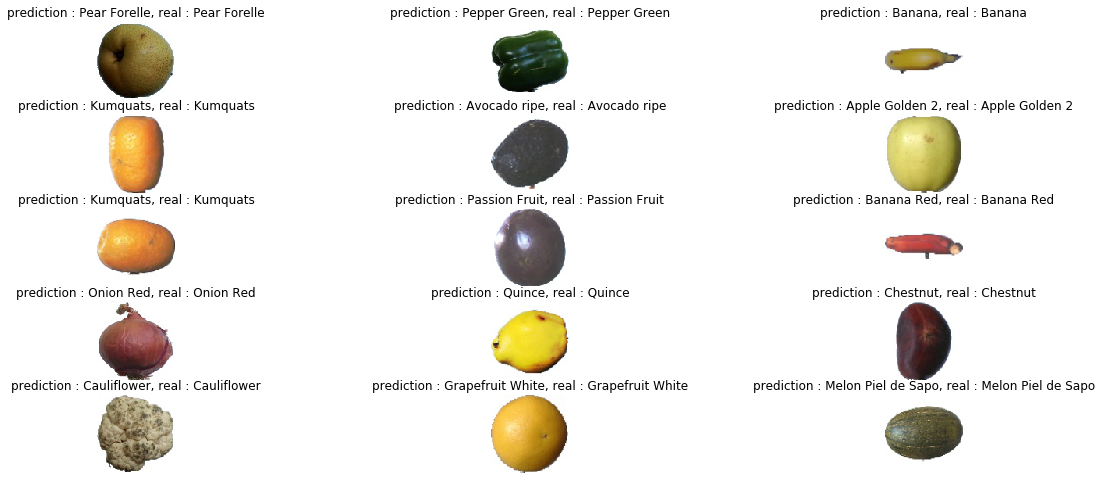

In [44]:
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=1,
                        shuffle=True)

# to unnormalize images, so we can see them better :)
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

plt.figure(figsize=(20,10))
columns = 3
with torch.no_grad():

    for i, (image, label) in enumerate(test_loader):
        if i == 15:
            break
        plotImg = inv_normalize(image[0])
        plt.subplot(15 / columns + 1, columns, i + 1)
        plt.imshow((plotImg.permute(1,2,0)))
        plt.axis("off")
        output = model(image)
        _, prediction = torch.max(output, 1)
        plt.title(f"prediction : {classes[prediction]}, real : {classes[label]}")